In [4]:
"""SOLUÇÃO MISSING PISCINA
1 - PoolQC referesse a qualidade da piscina nitidamente deve ser uma variável ordinal.
1.1 Todos os valores que não tem PoolArea e PoolQC praticamente coincidem. Ou seja, todos os valores PoolQC não informados
e que também não tem PoolArea são porque não tem piscina. A maioria da base tem essa característica.
1.2 Como são poucos registros com PoolQC informados em relação ao total adotar a distância de 1 entre as classificações 
será um bom critério. Tem somente 8 registros com SalePrice e como a correlação não é forte não parece razoável 
ponderar esses valores pelo SalePrice.
2.1 a analise do histograma para Qualidade Piscina mostrou que a mediana e a média apresentaram o mesmo valor 4.
2.2 Aqui cabe uma reflexão, esses valores que estavam vazios e tinham area fazem parte do BD teste e não tinham valor para 
variável target. 
2.3 Analise correlação entre PoolArea e PoolQC e SalePrice
2.3.1 existe uma correlação positiv(a maior a qualidade da piscina maior o preço da casa). Faz sentido, mas essa correlação
não ajuda a preencher os POOLQC nulos já  que esses itens não tem SalePrice.
2.3.2 A correlação entre área da piscina e qualidade da piscina é negativa. Não é tão significante -0.42 e é negativa.
Ou seja, quanto maior a área menor é a qualidade da piscina. Não faz muito sentido. E como a quantidade de registros são poucos
parece arriscado utilizar essa correlação para prever valores para PoolQC
2.3.3 São poucos itens, mas os poucos que tem não apresenta uma curva normalizada.

Interessante no treinamento adotar abordagens:
1 - Fazer simulação adotando valores ordinais crescentes conforme a qualidade. E os itens sem classificação que tem PoolArea
e não tem classificação adotar o valor zero. Talvez possa representar o fato de ter a area para piscina e não ter a piscina.

2 - Fazer simulação adotando valores ordinais crescentes conforme a qualidade. E os itens sem classificação que tem PoolArea
e não tem classificação adotar o valor medio. Assim, tratando como um erro de classificação os registros não classificados
devem interferir menos na predição.

3 - Já que existe uma correlação (mesmo fraca) entre SalePrice e PoolQC	adotar o Target encoding. Apontar os valores do
desvio padrão do target conforme correlação com a variável alvo. *** cuidado com overfitting.

4- Utiliza a correlação entre o item 3 mas proporcionaliza também considerando o ranking entre as variáveis.

"""
all_data['PoolQC'] = all_data['PoolQC'].apply(lambda x: 
                                                       4 if x in ['Ex'] else
                                                       3 if x in ['Gd'] else
                                                       2 if x in ['TA'] else
                                                       1 if x in ['Fa'] 
                                                       else x)
dbfilter = all_data[(all_data['PoolArea'] > 0) & (~all_data['PoolQC'].isnull()) & (~all_data['SalePrice'].isnull())]

dbfilter[['PoolArea','PoolQC', 'SalePrice']].sort_values(['PoolArea'], ascending=False)
mean_encode = dbfilter.groupby('PoolQC')['SalePrice'].std()
all_data['PoolQC'] = dbfilter['PoolQC'].map(mean_encode)
all_data.loc[(all_data['PoolArea'] > 0) & (~all_data['PoolQC'].isnull()), 'PoolQC'] = all_data.loc[(all_data['PoolArea'] > 0) & (~all_data['PoolQC'].isnull()), 'PoolQC'] * (dbfilter['PoolQC'] / dbfilter['PoolQC'].sum())
# as piscinas sem qualidade mais com area foi atribuido o desvio padrao da variavel target para todos os PoolQC classificados
all_data.loc[all_data['PoolQC'].isnull() & (all_data['PoolArea'] > 0), 'PoolQC'] = dbfilter['SalePrice'].std()
#aos demais itens sem area e sem qualidade piscina o campo qualidade foi atribuido 0
all_data['PoolQC'] = all_data['PoolQC'].fillna(0)

In [5]:
"""SOLUÇÃO MISSING MiscFeature
1 - MiscFeature referesse a caracteristica diferenciadas. Tipo: ter elevador, mais uma garagem, quadra de tenis. etc.
O valor é categorico e não é ordinal. Existe uma outra variavel MiscVal que apresenta o valor para a variavel MiscFeature.
2 - Tem um registro que tem MiscVal e não tem classificação. Como já existe uma MiscFeature com descrição "outros" pode-se
utiliza-la para classificar esse registro.
3 - Criado a categoria None para todos os registros que não tem MiscFeature e nem MiscVal.
4- Ficou uma varival categorica com com 5 possibilidades de classificação ('None', 'Shed', 'Gar2', 'Othr', 'TenC').
Como são poucas não vejo necessidade de diminir as dimensões.
5- Analise boxplot e de distribuição de frequencia não foi possível encontrar nada que possa sofrer ajuste de performance.
6-Uma tratativa eficiente é hot encoding que irá tratrar binariamente cada opção.
7-Depois de realizar o hot encoding foi feito analises para verificar associações com a variável alvo
8-TenC representa que a casa tem quadra de tenis algo que poderia ser um bom preditor porém de todos os registros da base
somente uma casa tem essa informação o que não ajuda na predição.
9-Analisando as correlações com a variavel alvo nenhuma das caracteristicas parece apresentar correlação ou algum poder
de predição. Talvez deletar seja a melhor opção.

*** Posteriormente é interessante criar uma variável que soma a variáve MiscVal com outros valores para verificar
a correlação com a variável SalePrice

"""
all_data.loc[(all_data['MiscFeature'].isnull()) & (all_data['MiscVal'] > 0), 'MiscFeature'] = 'Othr'
all_data.loc[(all_data['MiscFeature'].isnull()) & (all_data['MiscVal'] == 0), 'MiscFeature'] ='None'

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 
import xgboost as xgb
from scipy import stats
from scipy.stats import norm, skew
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score

from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from pandas.api.types import CategoricalDtype
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, Lasso, Ridge
import os
print(os.listdir('input'))
train = pd.read_csv('input2/train.csv')
test = pd.read_csv('input2/test.csv')

all_data = pd.concat((train, test), axis=0, sort=False).reset_index(drop=True)

['data_description.txt', 'test.csv', 'train.csv']


In [6]:
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
Alley,2721,0.932169
Fence,2348,0.804385
SalePrice,1459,0.499829
FireplaceQu,1420,0.486468
LotFrontage,486,0.166495
GarageCond,159,0.054471
GarageYrBlt,159,0.054471
GarageFinish,159,0.054471
GarageQual,159,0.054471
GarageType,157,0.053786


In [ ]:
"""SOLUÇÃO MISSING Alley
1 - MiscFeature referesse a caracteristica diferenciadas. Tipo: ter elevador, mais uma garagem, quadra de tenis. etc.
O valor é categorico e não é ordinal. Existe uma outra variavel MiscVal que apresenta o valor para a variavel MiscFeature.
2 - Tem um registro que tem MiscVal e não tem classificação. Como já existe uma MiscFeature com descrição "outros" pode-se
utiliza-la para classificar esse registro.
3 - Criado a categoria None para todos os registros que não tem MiscFeature e nem MiscVal.
4- Ficou uma varival categorica com com 5 possibilidades de classificação ('None', 'Shed', 'Gar2', 'Othr', 'TenC').
Como são poucas não vejo necessidade de diminir as dimensões.
5- Analise boxplot e de distribuição de frequencia não foi possível encontrar nada que possa sofrer ajuste de performance.
6-Uma tratativa eficiente é hot encoding que irá tratrar binariamente cada opção.
7-Depois de realizar o hot encoding foi feito analises para verificar associações com a variável alvo
8-TenC representa que a casa tem quadra de tenis algo que poderia ser um bom preditor porém de todos os registros da base
somente uma casa tem essa informação o que não ajuda na predição.
9-Analisando as correlações com a variavel alvo nenhuma das caracteristicas parece apresentar correlação ou algum poder
de predição. Talvez deletar seja a melhor opção.

*** Posteriormente é interessante criar uma variável que soma a variáve MiscVal com outros valores para verificar
a correlação com a variável SalePrice

"""

In [30]:
all_data['MiscFeature'].unique()

array(['None', 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [14]:
dbfilter = all_data[(~all_data['MiscFeature'].isnull()) | (all_data['MiscVal'] > 0)]
dbfilter[['MiscVal','MiscFeature', 'SalePrice']].sort_values(['MiscVal'], ascending=False)

,MiscVal,MiscFeature,SalePrice
2549,17000,NaN,NaN
346,15500,Gar2,151500.0
1461,12500,Gar2,NaN
1230,8300,Gar2,190000.0
2073,6500,Othr,NaN
...,...,...,...
1605,80,Shed,NaN
812,54,Shed,55993.0
873,0,Othr,133000.0
1200,0,Shed,116050.0


In [ ]:
""" 
tecnica para o item 1
all_data['PoolQC'] = all_data['PoolQC'].apply(lambda x: 
                                                       4 if x in ['Ex'] else
                                                       3 if x in ['Gd'] else
                                                       2 if x in ['TA'] else
                                                       1 if x in ['Fa'] 
                                                       else x)

all_data.loc[(all_data['PoolArea'] > 0) & (all_data['PoolQC'].isnull()), 'PoolQC'] = 0



tecnica para o item 2
all_data['PoolQC'] = all_data['PoolQC'].apply(lambda x: 
                                                       4 if x in ['Ex'] else
                                                       3 if x in ['Gd'] else
                                                       2 if x in ['TA'] else
                                                       1 if x in ['Fa'] 
                                                       else x)

all_data.loc[(all_data['PoolArea'] > 0) & (all_data['PoolQC'].isnull()), 'PoolQC'] = all_data[~all_data['PoolQC'].isnull() ]['PoolQC'].median()
"""

In [159]:
all_data['PoolQC']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
2914    0.0
2915    0.0
2916    0.0
2917    0.0
2918    0.0
Name: PoolQC, Length: 2919, dtype: float64

In [115]:
novodb = (dbfilter.loc[(dbfilter['PoolArea'] > 0) & (~all_data['PoolQC'].isnull()), 'PoolQC']/ dbfilter.loc[(dbfilter['PoolArea'] > 0) & (~all_data['PoolQC'].isnull()), 'PoolQC'].sum()) 
dbfilter['PoolQC'].map(mean_encode)

197     360624.458405
810      48790.367902
1170     63441.392639
1182    360624.458405
1298     63441.392639
1386     48790.367902
1423     63441.392639
Name: PoolQC, dtype: float64

In [137]:
all_data.loc[all_data['PoolQC'].isnull() & (all_data['PoolArea'] > 0)]['PoolQC'] = dbfilter['SalePrice'].std()

1974   NaN
2420   NaN
2503   NaN
2573   NaN
2599   NaN
2710   NaN
Name: PoolQC, dtype: float64

In [139]:
dbfilter['SalePrice'].std()

206071.8509346171

In [31]:
dbfilter[['MiscFeature','MiscVal', 'SalePrice']].corr()

,MiscVal,SalePrice
MiscVal,1.00000,-0.08161
SalePrice,-0.08161,1.00000


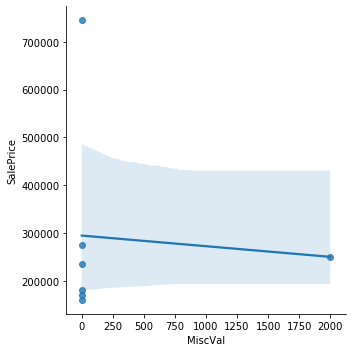

In [84]:
sns.lmplot(x='MiscVal',y='SalePrice',data=dbfilter)

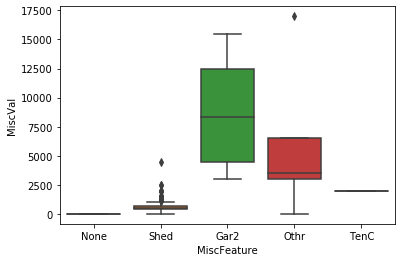

In [81]:
sns.boxplot(x='MiscFeature',y='MiscVal',data=all_data)
#sns.boxplot(x='MiscFeature',y='SalePrice',data=all_data)

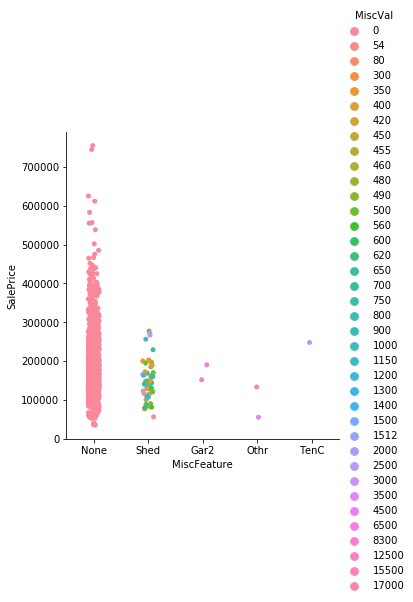

In [78]:
# grafico de frequencia por tipo de Miscellaneous
#all_data[(all_data['MiscFeature'].isin(['Shed','Gar2','TenC','Othr']))][['MiscFeature']].groupby('MiscFeature').size().plot(kind='bar')

sns.catplot(x="MiscFeature", y="SalePrice", hue="MiscVal", data=all_data);

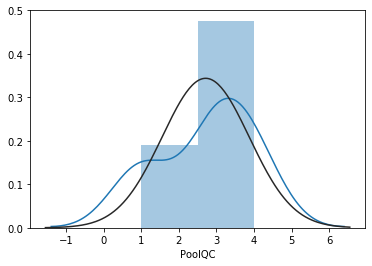

In [82]:
sns.distplot(dbfilter['PoolQC'] , fit=norm);

In [87]:
all_data.loc[all_data['MiscFeature']=='Othr'][['MiscFeature', 'SalePrice','MiscVal']]

#sns.boxplot(x='MiscFeature',y='MiscVal',data=all_data)

,MiscFeature,SalePrice,MiscVal
705,Othr,55000.0,3500
873,Othr,133000.0,0
2073,Othr,NaN,6500
2549,Othr,NaN,17000
2697,Othr,NaN,3000


In [92]:
MiscFeature = pd.get_dummies(all_data['MiscFeature'])
MiscFeature['SalePrice'] = all_data['SalePrice']

In [112]:
MiscFeature2.corr()

,Gar2,None,Othr,Shed,TenC,SalePrice
Gar2,1.000000,NaN,-0.038462,-0.613941,-0.026939,0.071441
None,NaN,NaN,NaN,NaN,NaN,NaN
Othr,-0.038462,NaN,1.000000,-0.613941,-0.026939,-0.215242
Shed,-0.613941,NaN,-0.613941,1.000000,-0.430007,-0.026016
TenC,-0.026939,NaN,-0.026939,-0.430007,1.000000,0.257373
SalePrice,0.071441,NaN,-0.215242,-0.026016,0.257373,1.000000


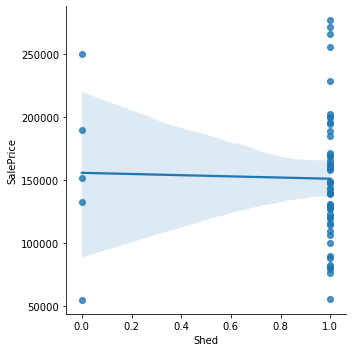

In [111]:
sns.lmplot(x='Shed',y='SalePrice',data=MiscFeature2)

In [118]:
pd.set_option('display.max_rows', 500)
MiscFeature2 = MiscFeature[((MiscFeature['Shed']==1) | (MiscFeature['Othr']==1) | (MiscFeature['Gar2']==1) | (MiscFeature['TenC']==1)) & 
           (MiscFeature['SalePrice']>0)].sort_values(by=['SalePrice'], ascending=False)

In [119]:
MiscFeature2

,Gar2,None,Othr,Shed,TenC,SalePrice
249,0,0,0,1,0,277000.0
539,0,0,0,1,0,272000.0
1457,0,0,0,1,0,266500.0
1328,0,0,0,1,0,256000.0
1386,0,0,0,0,1,250000.0
335,0,0,0,1,0,228950.0
338,0,0,0,1,0,202500.0
7,0,0,0,1,0,200000.0
800,0,0,0,1,0,200000.0
766,0,0,0,1,0,196500.0
